In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

# QUESTION 1

### Training the DQN Model

In [2]:
#Final Fixed Hyperparameters
NUM_RUNS = 10
EPSILON_INITIAL = 1.0
EPSILON_DECAY = 0.006
EPSILON_MINIMUM = 0.05
INITIAL_LEARNING_RATE = 0.001
LEARNING_RATE_DECAY = 0.004
EPISODES = 500

#Final Variable Hyperparameters
EXPERIENCE_REPLAY_MEMORY = 21000
EXPERIENCE_REPLAY_BATCH_SIZE = 130
UPDATE_TARGET_POLICY = 3
SIZE_NEURAL_NETWORK = 2**7

runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,SIZE_NEURAL_NETWORK,SIZE_NEURAL_NETWORK,2]) #Number of in features and out features
    target_net = DQN([4,SIZE_NEURAL_NETWORK,SIZE_NEURAL_NETWORK,2])
    update_target(target_net, policy_net)
    target_net.eval()

    memory = ReplayBuffer(EXPERIENCE_REPLAY_MEMORY)

    steps_done = 0

    episode_durations = []

    for i_episode in range(EPISODES):
        EPSILON = max(EPSILON_MINIMUM, EPSILON_INITIAL * np.exp(-EPSILON_DECAY * i_episode))
        LEARNING_RATE = INITIAL_LEARNING_RATE * np.exp(-LEARNING_RATE_DECAY * i_episode)
        optimizer = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", EPISODES)
            print('Epsilon:', EPSILON, "Learning Rate:", LEARNING_RATE)
            print()

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < EXPERIENCE_REPLAY_BATCH_SIZE:
                transitions = memory.sample(EXPERIENCE_REPLAY_BATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % UPDATE_TARGET_POLICY == 0: 
            update_target(target_net, policy_net)
            

    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10


/Users/ganesh/Desktop/Reinforcement Learning/RL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 500
Epsilon: 0.7452764914432887 Learning Rate: 0.0008220122346781865

episode  100 / 500
Epsilon: 0.5521144043069306 Learning Rate: 0.0006730066959373864

episode  150 / 500
Epsilon: 0.4090164106114069 Learning Rate: 0.0005510112789913408

episode  200 / 500
Epsilon: 0.3030068095387654 Learning Rate: 0.00045112987940304234

episode  250 / 500
Epsilon: 0.22447296549695234 Learning Rate: 0.000369353905899632

episode  300 / 500
Epsilon: 0.16629366289060088 Learning Rate: 0.0003024014015294998

episode  350 / 500
Epsilon: 0.12319337545326038 Learning Rate: 0.00024758532720608453

episode  400 / 500
Epsilon: 0.09126389720305915 Learning Rate: 0.0002027057213944961

episode  450 / 500
Epsilon: 0.0676099579384495 Learning Rate: 0.00016596140793053137

episode  500 / 500
Epsilon: 0.05008668874032793 Learning Rate: 0.00013587770849684614

Starting run 2 of 10
episode  50 / 500
Epsilon: 0.7452764914432887 Learning Rate: 0.0008220122346781865

episode  100 / 500
Epsilon: 0.55211440

### Plot Learning Curve

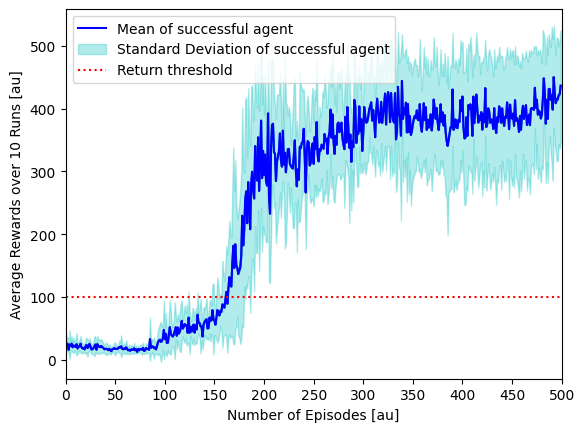

In [3]:
# Plotting the learning curve

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(EPISODES), means)
plt.ylabel("Average Rewards over 10 Runs [au]")
plt.xlabel("Number of Episodes [au]")
plt.plot(np.arange(EPISODES), means, label='Mean of successful agent', color='b')
plt.fill_between(np.arange(EPISODES), means, means + stds, alpha=0.3, color='c', label='Standard Deviation of successful agent')
plt.fill_between(np.arange(EPISODES), means, means - stds, alpha=0.3, color='c')
plt.axhline(y=100, label='Return threshold', color='red', linestyle='dotted')

plt.xlim(0,500)
plt.xticks(np.arange(0, EPISODES+1, 50))

plt.legend()
plt.savefig('Learning_Curve.png', dpi=500)
plt.show()

## Experimentation

### The experiment was conducted by adding for loops to the DQN model training code for each hyperparameter and their range of values (as mentioned in the report). The next section of the code talks about how the data was processed and how the average rewards were calculated. The average rewards for each hyperparameter and their values can be found in the last cell for this section

In [4]:
#Function to calculate the average reward after the learning curve has stabalised for each hyperparameter and their values
def average_score(final_results, measure_average, episode_start):
    for index, res in enumerate(final_results):
        sum = 0
        for res_inner in res:
            sum += np.mean(res_inner[episode_start[index]:])
        measure_average.append(sum/4)
    
    return measure_average

In [5]:
#Take note this cell has to be run for each hyperparameter
measure_average = [] #Used to store the final averages (as seen in the next cell)
episode_start = [] #Used to store the episode where the learning curve starts to plateau, after which the average is taken
DQN_returns = [] #Used to store the returns of the DQN agent for a specific hyperparameter and their range of values
measure_average = average_score(DQN_returns, measure_average, episode_start)

In [6]:
#Final Average Rewards for each hyperparameter and their range of values
measure_average_experience_replay_memory = [274.815, 321.9066666666667, 355.0575, 367.62666666666667, 328.0416666666667] #18,000 to 22,000, in steps of 1000
measure_average_experience_replay_batch_size = [334.875, 270.71833333333336, 323.80249999999995, 394.19875, 309.67375000000004, 288.74] #100 to 150, in steps of 10
measure_average_update_target_policy = [410.79875, 363.059, 402.11899999999997, 300.0, 207.5] #3 to 7, in steps of 1 (6 and 7 were excluded from the final results due to worsening leraning curves)
measure_average_size_neural_network = [168.5, 219.0, 265.21, 264.55400000000003, 268.065, 342.797] #2**3 to 2**7, in steps of 1, (Corresponding Hidden Layer Size: 8 to 128)

# QUESTION 2

In [7]:
def plotSlices(q):
    cart_velocity = [0., 0.5, 1.0, 2.0] 
    angle_range = 0.2095
    omega_range = 6 

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()

    if q:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    for index, v in enumerate(cart_velocity):
        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0., v, angle, omega])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
        if q:
            hi = axs[index].contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
            axs[index].set_title(f'Cart Velocity = {v} m/s')
        else:
            hi = axs[index].contourf(angles, omegas, policy_array.T, cmap='cividis')
            axs[index].set_title(f'Cart Velocity = {v} m/s')
        
    for ax in axs:
        ax.set_xlabel("angle [rad]")
        ax.set_ylabel("angular velocity [rad/s]")

    if q:
        cbar = fig.colorbar(hi, cax=cbar_ax)
        cbar.set_label('Range of Q values and their respective colours')

    if q:
        plt.savefig('Q_Plot_Slices.png', dpi=500)
    else:
        plt.savefig('Policy_Plot_Slices.png', dpi=500)

    plt.show()

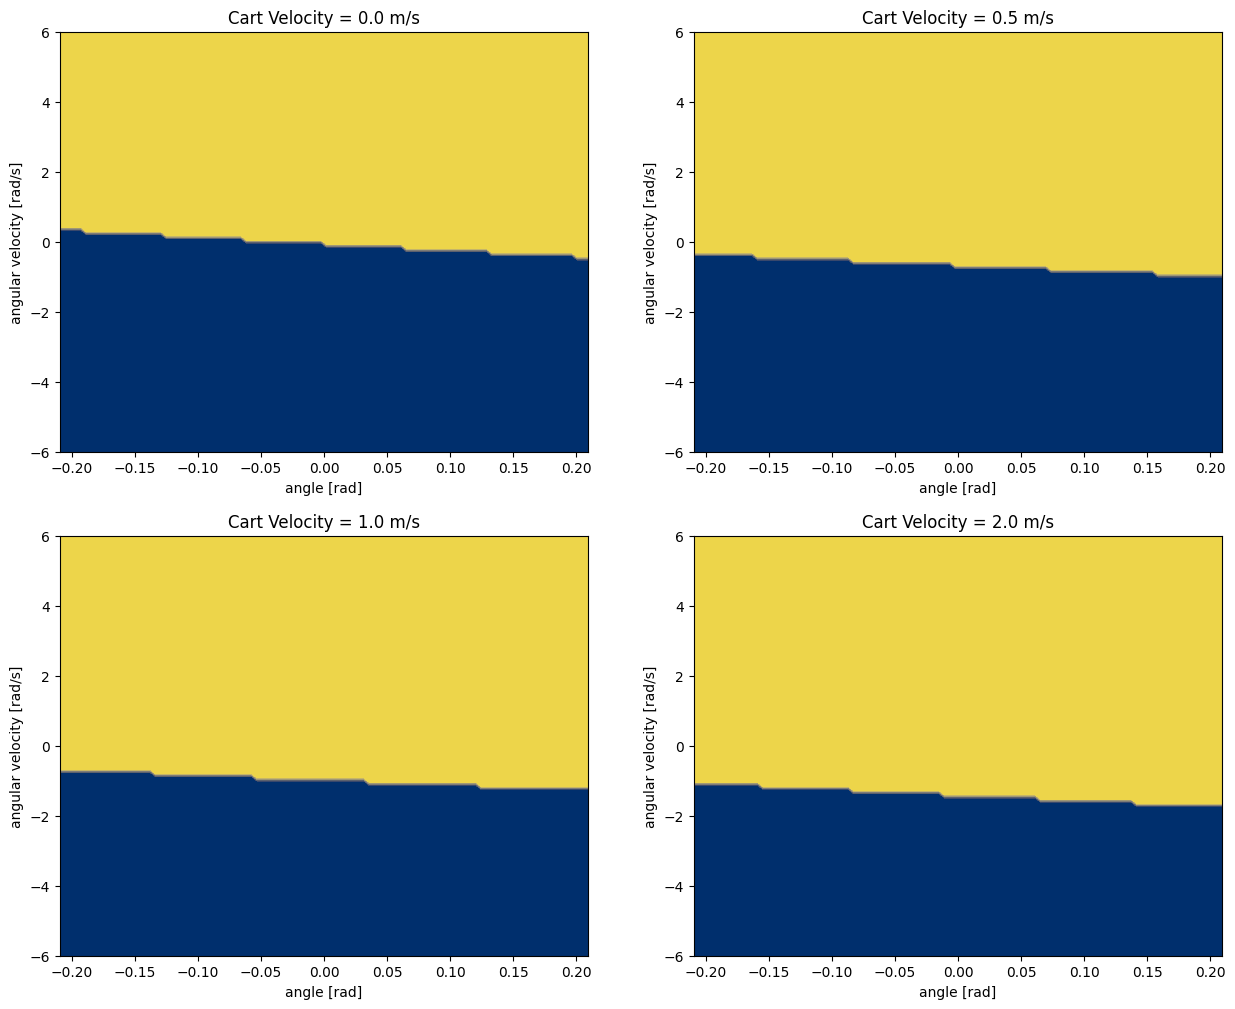

In [8]:
#Slices of the greedy policy action
plotSlices(False)

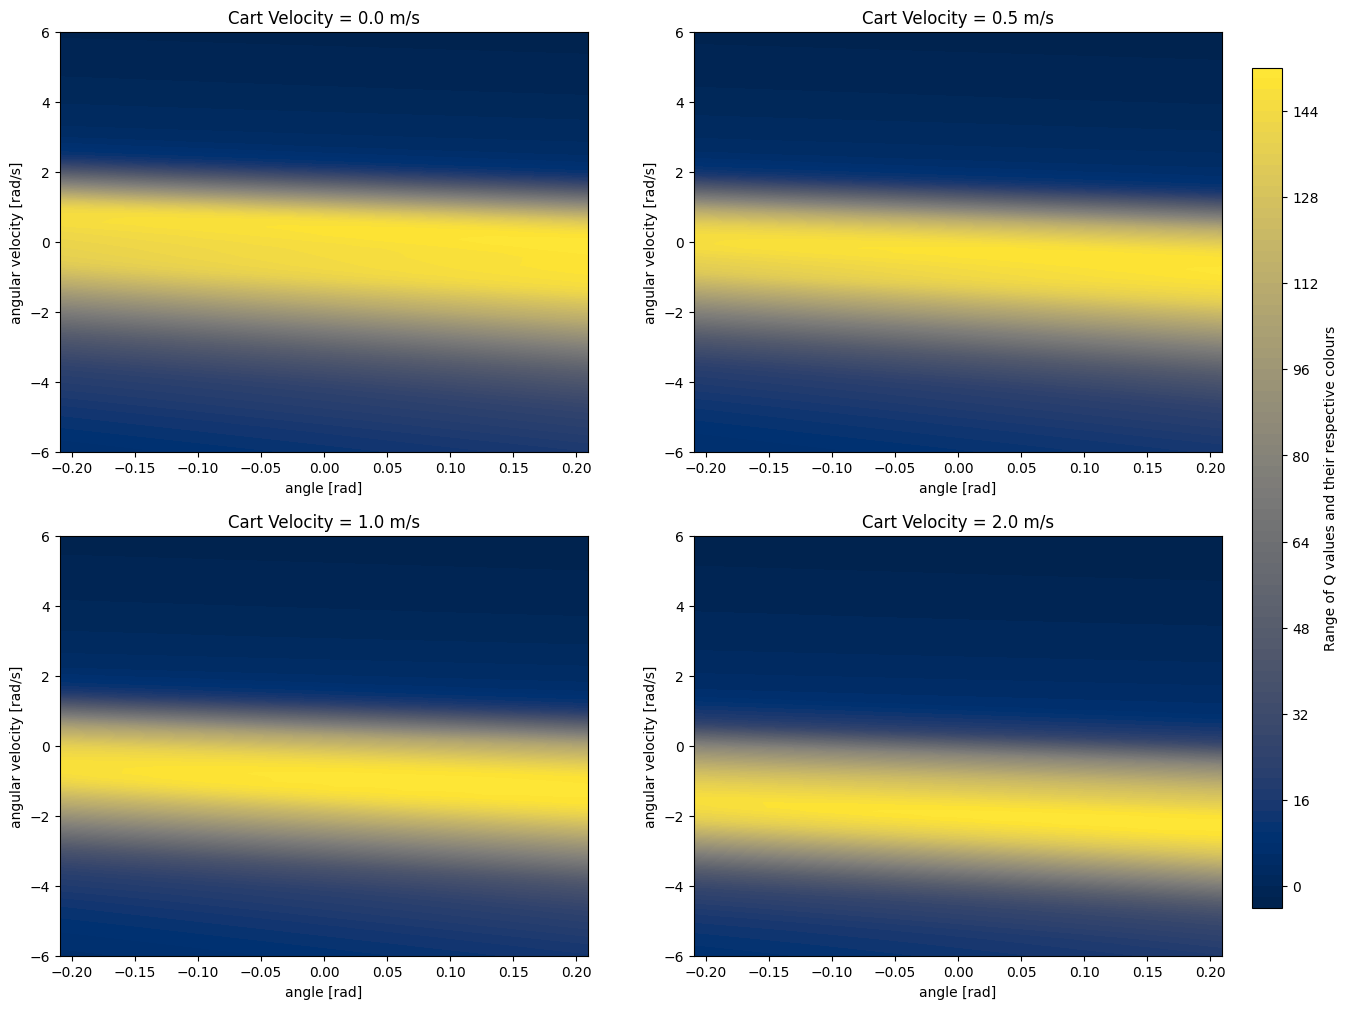

In [9]:
#Slices of the Q function
plotSlices(True)